## Работа с текстовыми данными

IMDB датасет содержит в себе 50 000 обзоров на фильмы, с проставленным эмоциональным оттенком. Задача называется анализ тональности (sentiment classification). Мы должны определить является обзор на фильм положительным или отрицательным (1 - 0). Датасет хорошо размечен и содержит в себе только поляризированные отзывы (негативные ≤ 4 из 10, положительные ≥ 7 из 10). По 25 000 примеров для обучения и для валидации.

Найти датсет можно тут.
http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [76]:
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [77]:
PATH= r'data\\aclImdb\\'
names = ['neg','pos']

In [78]:
!dir {PATH}

 Том в устройстве C не имеет метки.
 Серийный номер тома: 9094-10A6

 Содержимое папки C:\Users\Данила\schoolAI\data\aclImdb

06.11.2018  11:22    <DIR>          .
06.11.2018  11:22    <DIR>          ..
12.04.2011  20:14           845 980 imdb.vocab
12.06.2011  01:54           903 029 imdbEr.txt
26.06.2011  03:18             4 037 README
06.11.2018  11:22    <DIR>          test
06.11.2018  11:22    <DIR>          train
               3 файлов      1 753 046 байт
               4 папок   6 965 669 888 байт свободно


Сейчас каждый обзор лежит в отдельном .txt файле в папках pos и neg. Нам надо прочесть все файлы для работы из питона.

In [79]:
def texts_labels_from_folders(path, folders):
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        files_list = os.listdir(os.path.join(path, label))
        files_path = [os.path.join(path, label, f) for f in files_list]
        for fname in files_path:
            texts.append(open(fname, 'r', encoding="utf8").read())
            labels.append(idx)
    return texts, np.array(labels).astype(np.int64)

In [80]:
trn,trn_y = texts_labels_from_folders(f'{PATH}train',names)
val,val_y = texts_labels_from_folders(f'{PATH}test',names)

Теперь у нас есть переменные trn и trn_y, в каждой из которых лежит по 25000 строк - обзоров на фильм. И val и val_y где лежит метка 0 или 1, для негативного или положительного отзыва.

Посмотрим на один элемент из обучающей выборки.

In [39]:
trn[0], trn_y[0]

("Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.",
 0)

Но сейчас мы не можем обучить нашу модель, хоть у нас и есть данные. Каждая обучающая выборка из X это уникальная строка (обзор на фильм), и вряд ли мы когда нибудь встретим ещё один такой же обзор, чтобы наша модель смогла сдлеать успешное предсказание.

Одно из решений, поделить каждый обзор на слова, чтобы нашими новыми фичами были отдельные слова, а не обзор целиком.

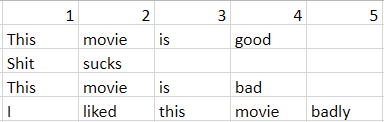

In [81]:
from IPython.display import Image
Image(filename='img/l7_1.png')

Если мы разобьём таким образом, что у нас будет фича "первое слово", "второе слово" .... "500е слово", то от проблемы того, что каждый обзор уникален мы не уйдём, просто приобретём не 1 фичу, а N фич. К тому же обзоры могут отличаться по длине, но это не столь большая проблемы, мы всегда можем доставить в конец нужное количество нулей. Значит нужно сделать фичей не порядковый номер слова, а само слово.

Такое подход называется мешок слов (Bag of words, BoW). Тогда наш пример преобразится в следующий вид.

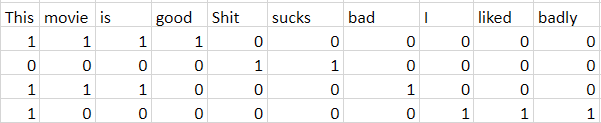

In [82]:
Image(filename='img/l7_2.png')

В python есть соответствующий обработчик. Для построение матрицы BoW.

In [83]:
veczr = CountVectorizer()

In [84]:
trn_term_doc = veczr.fit_transform(trn)
val_term_doc = veczr.transform(val)

Получается, что каждая строка, это один обзор фильма, а каждый столбец это одно слово. Посмотрим на размер получившейся матрицы.

In [85]:
trn_term_doc.shape

(25000, 74849)

Строк 25000, а столбцов 74849. Это значит что в нашем обучающем наборе данных 75к разных слов. 25000х74849 - довольно большая матрица

$25K * 75K * 8 bytes = 15 GB$

Но почти целиком эта матрица состоит из 0, ведь редко какая рецензия будет использовать все слова. Значит мы можем оптимизировать хранение такой матрицы. Для этого используются разреженные матрицы (sparse matrix). Которые хранят только номера элементов отличных от 0.

In [86]:
trn_term_doc

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

Разреженное представление всегда можно конвертировать в обычно, но не стоит этого делать для всей матрицы.

In [87]:
trn_term_doc[0].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Можем посмотреть из чего состоит наш словарь.

In [88]:
vocab = veczr.get_feature_names(); vocab[5000:5005]

['augustine', 'augusto', 'augustus', 'auh', 'auie']

Теперь у нас есть всё для обучения модели. Данные в подходящем виде и ответы к ним. Обучим простую логистическую регрессию.

In [89]:
x=trn_term_doc
y=trn_y

In [90]:
m = LogisticRegression()
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

0.86672

86% точность - довольно хороший результат. 

Посмотрим на отдельные предсказания.

In [94]:
val[0]

"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in."

In [95]:
m.predict(val_term_doc[0])

array([0], dtype=int64)

In [96]:
val_y[0]

0

Разбиение текста на отдельные слова работает хорошо, но ещё лучше будет если мы сможем получать смысл не только из отдельных слов, но и из фраз или речевых оборотов. Для этого используют ngram-ы. При разбиении фразы "I liked this movie badly" с использованием 2-gram мы получим токены "I", "liked", "this", "movie", "badly", "I liked", "liked this", "this movie", "movie badly".

Попробуем.

In [97]:
veczr = CountVectorizer(ngram_range=(1,3), max_features=800000)
trn_term_doc = veczr.fit_transform(trn)
val_term_doc = veczr.transform(val)

In [98]:
trn_term_doc.shape

(25000, 800000)

In [99]:
vocab = veczr.get_feature_names()

Теперь наш словарь так же состоит из фраз

In [100]:
vocab[100000:100005]

['children are taught',
 'children are too',
 'children are watching',
 'children around',
 'children artwork']

In [101]:
x=trn_term_doc
y=trn_y

In [102]:
m = LogisticRegression()
m.fit(x, y)
preds = m.predict(val_term_doc)
(preds==val_y).mean()

0.8976

Улучшили наш результат до 89%. Для простых задач текстовых классификаций, это быстрый и годный метод.

Но у нас всё равно имеются некоторые проблемы с такой моделью. В первую очередь это огромное количество параметров 75к на входном слое для очень-очень простого словаря, при использовании n-gram уже > 800к. При построении нейронной сети, такое количество весов будет необучаемо.

Так же в нашей модели представления слов, каждое слово это отдельно взятая сущность, не имеющая никакого сходства с другими словами.

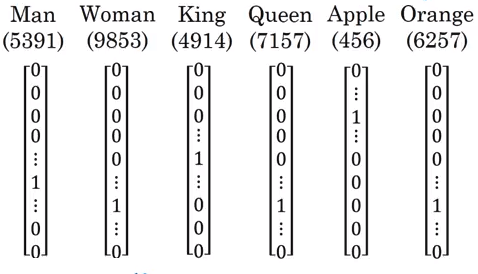

In [103]:
Image(filename='img/l7_3.png')

Каждое слово это вектор состоящий из 0, кроме 1 позиции. Но с человеческое точки зрения это неверно. Между яблоком и апельсином гораздо больше сходства, чем между яблоком и человеком. Однако сходство между векторами будет одинаково - 0. Кстати, мерой сходства векторов часто определяют косинусное расстоние.

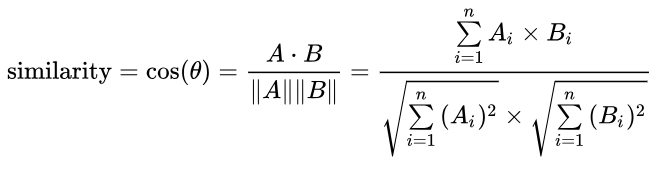

In [104]:
Image(filename='img/l7_4.png')

## Word embedding

Мы бы хотели, чтобы у каждого слова были какие то свойства, которые может слово обозначать. Например.

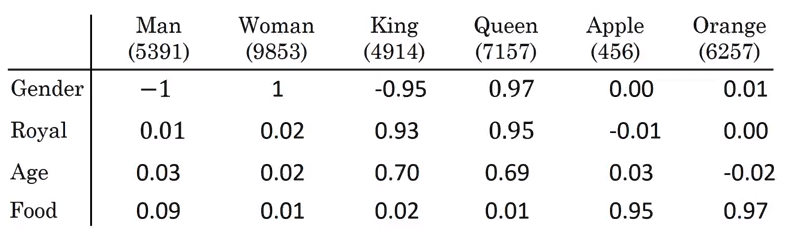

In [107]:
Image(filename='img/l7_5.png')

В данном случае у нас есть какие то свойства, а слово имеет это свойство или нет. Например и яблоко и банан это еда, люди это не еда. У людей есть пол, а у фруктов нет и т.д.

Если мы сконструируем такую матрицу, то по яблоко и апельсин будет иметь гораздо больше общего.

Но конечно эти свойства мы не будем задавать вручную, и скорее всего они не будут иметь такого человеко-понятного значения, как в примере выше. Это будет произвольное количество строк x1-x2-x3-....xN. Где N мы можем выбрать равным любому числу, допустим 300. Тогда матрица embedding-ов у нас будет иметь размерность 300х(Количество_слов). В этой матрице, каким то образом будет отражаться смысл каждого слова при помощи 300 чисел.

Но как получить эту матрицу, как машина узнает смысл слов?

Давайте рассмотрим пример, где у нас есть некое слово bardiwac. Я не знаю его смысл, вы, вероятно, тоже. Посмотрим на примеры предложений, где оно используется.

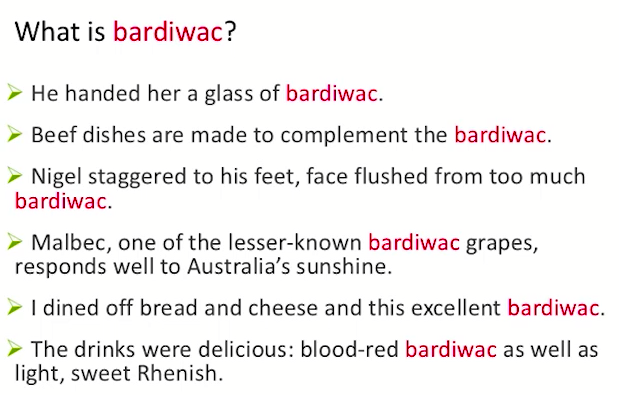

In [108]:
Image(filename='img/l7_6.png')

Похоже что это красный алкогольный напиток, сделанный из винограда.

Посмотрим на некоторые предложения.

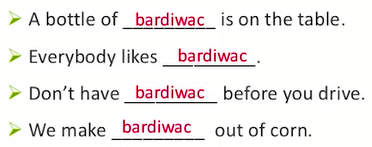

In [109]:
Image(filename='img/l7_7.png')

А какие ещё слова могут использоваться в этих контекстах?

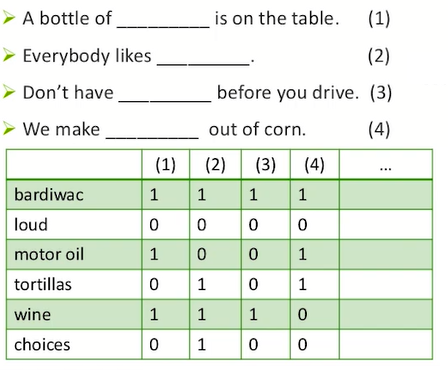

In [111]:
Image(filename='img/l7_9.png')

Правда ли что слова встречающиеся в похожих контекстах так же похожи?

Это именно то, о чём говорит нам дистрибутивная гипотеза. Которая звучит так:

### "You shall know a word by the company it keeps."

Как в этом случае машина будет собирать данные.

Просто берём все данные которые у нас есть, и считаем сколько раз слово встретилось в контексте другого слова.

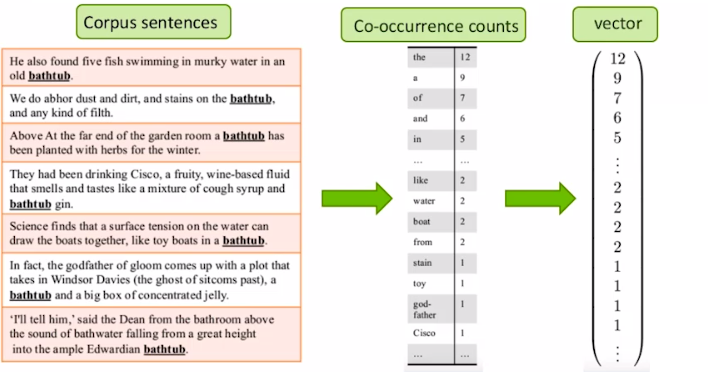

In [113]:
Image(filename='img/l7_10.png')

Теперь у нас есть вектор для слова, который как то отражает его смысл. Но длина этого вектора по прежнему равна длине словаря. А матрица со-встречаемостей вообще имеет размерность (Длина_словаря)х(Длина_словаря).

Вариант 2: Составляем матрицу где строки это документы, а столбцы это сколько раз слово встретилось в документе. Применив к этой матрице SVD разложение (линейная алгебра). Мы получим 3 матрицы поменьше. Первая будет описывать схожесть документов, а третья как раз схожесть слов.

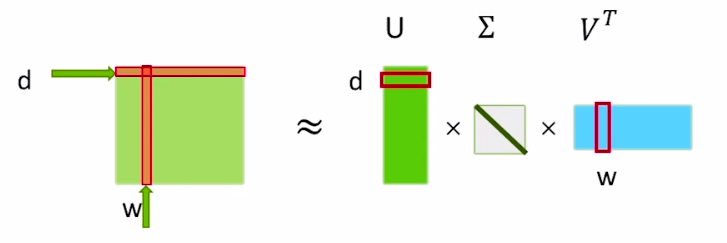

In [115]:
Image(filename='img/l7_11.png')

Такой подход называется латентным семантическим анализом (Latent semantic analisis, LSA). При таком подходе, мы сможем получить вектор отражающий смысл слова, и размерность этого вектора будет гораздо меньше длины словаря. Метод работает хорошо, но долго.

Вообще для большинства задач, для простых смертных это очень хороший рабочий вариант. Но для компаний как Яндекс или Гугл, критически важно, отслеживать изменения в значении слова ежесекундно. Поскольку с каким нибудь новым твитом может появиться новый мемасик или дока2.

Самый продвинутый подход это использовать нейронные сети. А модели для обучения слов есть разные, самые популярные это Word2Vec, GloVe и fastText.

Подробно рассказывать как они работают я не буду, лишь кратко опишу модель Word2Vec.

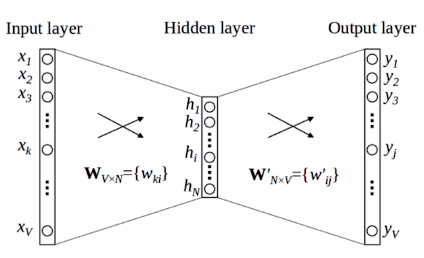

In [116]:
Image(filename='img/l7_12.png')

У нас есть предложение и любое слово мы в нём помечаем как target - наше целевое слово. Для этого слова мы хотим предсказать вероятность того, что около него встретится любое слово из его контекста

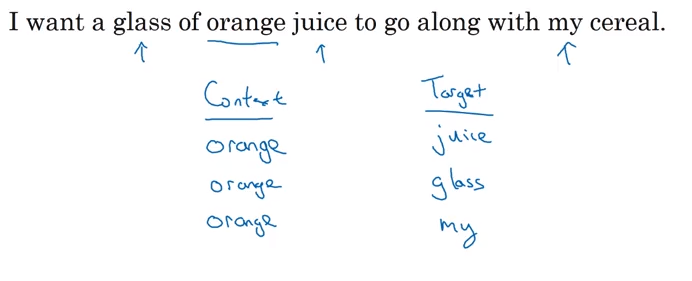

In [117]:
Image(filename='img/l7_13.png')

Допустим мы выбрали "orange" и хотим для него предсказать "juice" или "glass" или "my". Применив такую схему мы обучим веса в нашем скрытом слое (hidden layer), которые и будут представлениями наших слов.

Не стал я описывать работу по получению word2Vec модели, потому что нам редко придётся её обучать самим. Так же как и в работе с изображениями и свёрточными нейронными сетями, существует большое количество уже обученных моделей. Ими и будем пользоваться.

Для работы потребуются дополнительные модули. Командную строку от имени администратора.

pip install --upgrade nltk gensim bokeh

Нам потребуются данные. В этот раз это будут вопросы с Quora. Скачаем их по адресу https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1

In [120]:
data = list(open("data/quora.txt", 'r', encoding="utf8"))
data[50]

"What TV shows or books help you read people's body language?\n"

Это не размеченные данные, просто набор вопросов с ресурса https://www.quora.com/

Для начала всё же обучим наш word2Vec при помощи пары команд.

Разбиваем фразы на слова, очищая от пунктуации и прочего (токенизируем)

In [121]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

print(tokenizer.tokenize(data[50]))

['What', 'TV', 'shows', 'or', 'books', 'help', 'you', 'read', 'people', "'", 's', 'body', 'language', '?']


Приводим все слова к нижнему регистру.

In [123]:
data_tok = [tokenizer.tokenize(sent.lower()) for sent in data]

In [129]:
%%time
from gensim.models import Word2Vec
model = Word2Vec(data_tok, 
                 size=32,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

Wall time: 21.9 s


Теперь мы можем представить любое слово (которое есть в словаре) в виде вектора чисел!

In [126]:
model.get_vector('anything')

array([ 2.0257392 , -1.9593014 ,  0.42068645,  2.9795656 ,  2.4784865 ,
       -0.96493626,  0.91520643,  1.3937445 ,  4.47132   ,  1.0199215 ,
       -1.5679564 , -2.74522   , -0.9416056 , -0.24757601,  1.627602  ,
        2.2988372 , -1.3798155 ,  0.27399406,  2.522009  , -0.25156   ,
        2.422305  ,  1.1795144 ,  3.2654743 , -2.6695487 ,  3.0833755 ,
        0.9180883 , -2.059582  , -0.60985583, -1.0123726 , -2.083211  ,
       -1.8836043 , -2.1878574 ], dtype=float32)

Или наиболее похожие слова. Смело меняйте слово.

In [128]:
# or query similar words directly. Go play with it!
model.most_similar('putin')

C:\Users\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('vladimir', 0.8792810440063477),
 ('sanders', 0.843867301940918),
 ('bernie', 0.8374970555305481),
 ('hitler', 0.8227830529212952),
 ('reince', 0.8175919055938721),
 ('mike', 0.8142465949058533),
 ('churchill', 0.8084056377410889),
 ('murder', 0.8062223792076111),
 ('edward', 0.7983638048171997),
 ('genocide', 0.7972049713134766)]

Даже при крошечном датасете и векторе длиной всего 32, это заняло время. При обучении на корпусах вроде википедии 20+ GB это будет ещё дольше. Давайте лучше пользоваться уже обученными моделями.

In [130]:
import gensim.downloader as api
# 387 Mb
model = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [131]:
model.most_similar('putin')

C:\Users\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ukraine', 0.671127438545227),
 ('vladimir', 0.6658517122268677),
 ('merkel', 0.6268894076347351),
 ('coup', 0.6142057180404663),
 ('russia', 0.5971943736076355),
 ('hollande', 0.5897535085678101),
 ('ptin', 0.572974681854248),
 ('putain', 0.5696442127227783),
 ('assad', 0.5693070888519287),
 ('jai', 0.5669581294059753)]

У embedded векторов есть одно интересное свойство, которое вытекает из того, что теперь мы умеем находить схожесть слов и имеем вектор "смысла" слова. Это свойство не было целью этого алгоритма, и явилось лишь побочным эффектом.

Если мы вернёмся к нашему условному представлению.

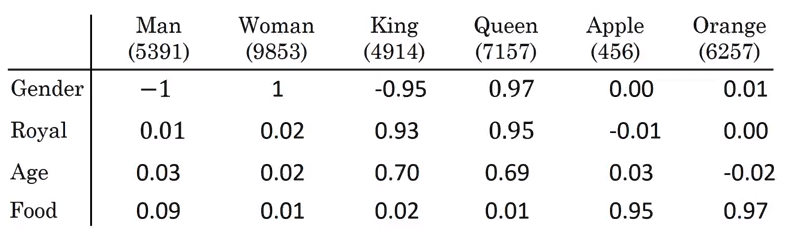

In [132]:
Image(filename='img/l7_5.png')

Мы зададимся вопросом о аналогиях: Мужчина <-> Женщина, относятся кдруг к дургу как Король <-> ??? . Люди поняли, что правильный ответ Король <-> Королева. Но как это поймёт машина?

Давайте посмотрим на разность векторов E(мужчина) - Е(женщина). А так же на разность векторов E(король) - Е(королева)

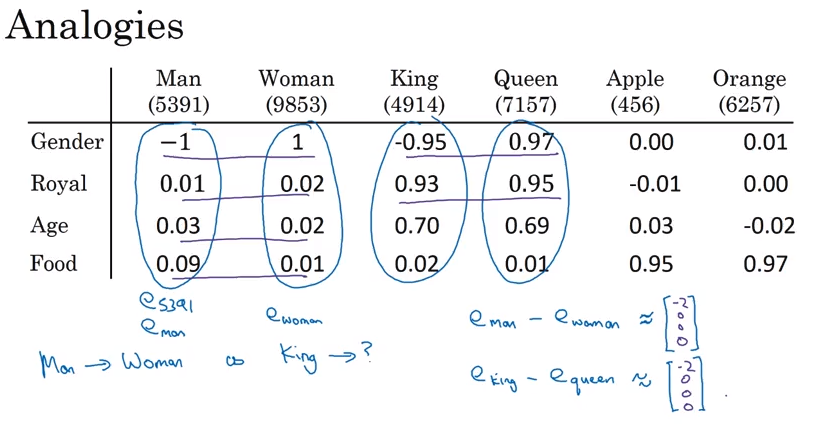

In [133]:
Image(filename='img/l7_14.png')


Мы увидим что векторы разностей практически равны. По этому мы сможем воспользоваться уравнением 

$E(мужчина) - Е(женщина) \approx E(король) - Е(X)$<br>
$Е(X) \approx E(король) - E(мужчина) + Е(женщина)$

Попробуем на нашей модели

In [134]:
model.most_similar(positive=["king", "woman"], negative=["man"])

C:\Users\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.7052314877510071),
 ('prince', 0.6666139364242554),
 ('mother', 0.6436765193939209),
 ('royal', 0.6417250633239746),
 ('father', 0.5952690243721008),
 ('african', 0.5883978009223938),
 ('princess', 0.5882176160812378),
 ('called', 0.5842776298522949),
 ('meets', 0.5840279459953308),
 ('american', 0.5815179944038391)]

Удивительно, но работает. Попробуем что нибудь повеселее.

In [138]:
model.most_similar(positive=["coder", "money"], negative=["brain"])

C:\Users\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('broker', 0.5820155143737793),
 ('bonuses', 0.5424473285675049),
 ('banker', 0.538511335849762),
 ('designer', 0.5197198390960693),
 ('merchandising', 0.4964233636856079),
 ('treet', 0.49220195412635803),
 ('shopper', 0.4920561611652374),
 ('part-time', 0.49128279089927673),
 ('freelance', 0.4843311905860901),
 ('aupair', 0.4796452820301056)]

Если бы мы попробовали изобразить 100 мерное пространство на 2-х мерном графике, отношение между этими понятиями могло бы выглядеть вот так


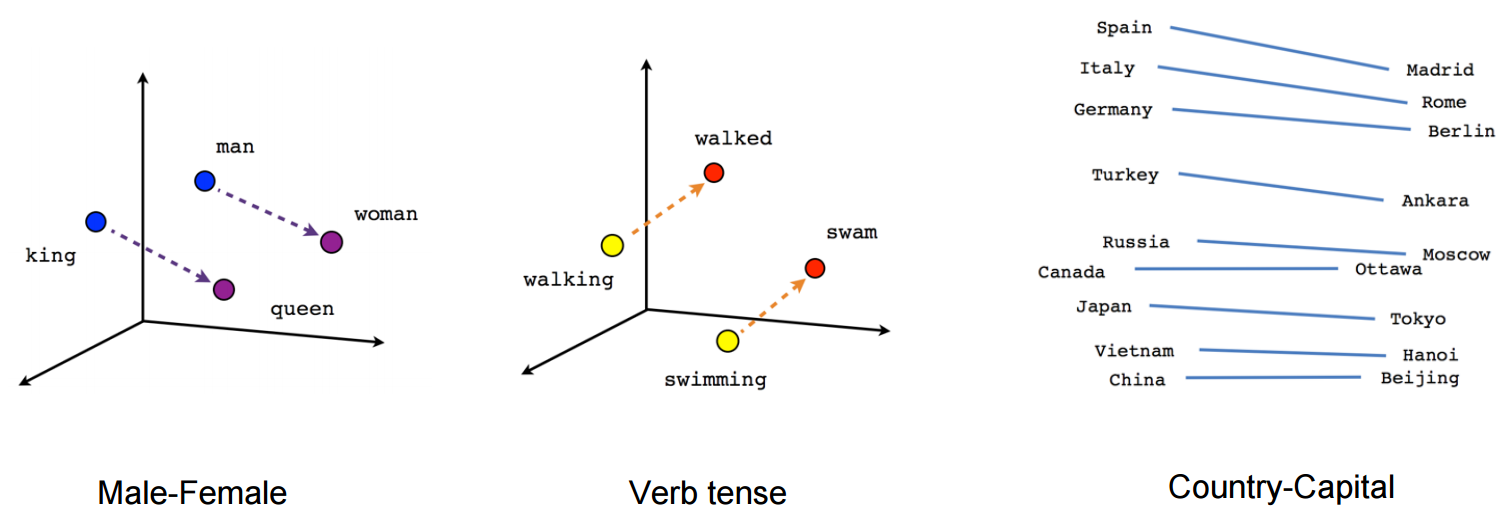

In [155]:
Image(filename='img/l7_15.png')

Так же мы можем попробовать визуализировать слова при помощи других методов уменьшения размерности пространства.

Вначале PCA наипростейший метод из линейного исчесления, который позволяет уменьшить размерность пространства, оставляя лишь те размерности, где есть наибольшая дисперсия.

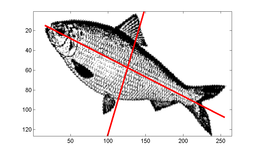

In [161]:
Image(filename='img/l7_16.png')

In [164]:
words = sorted(model.vocab.keys(), 
               key=lambda word: model.vocab[word].count,
               reverse=True)[:5000]

print(words[::100])

['<user>', '_', 'please', 'apa', 'justin', 'text', 'hari', 'playing', 'once', 'sei', 'mesmo', 'ainda', 'bang', 'radio', 'sounds', 'kinda', 'sekolah', 'dicen', 'hehehe', 'lead', 'الف', 'basketball', 'hotel', 'despues', 'din', 'earth', 'email', 'sh', 'jan', 'mucha', 'fais', 'airport', 'stfu', 'rato', 'ناس', 'شر', 'lls', 'area', 'dai', 'tenia', 'fox', 'emotional', 'scene', 'create', 'makanya', 'common', 'colombia', 'budak', 'جديد', 'και']


In [165]:
# for each word, compute it's vector with model
word_vectors = np.array([model.get_vector(wrd) for wrd in words])

In [166]:
from sklearn.decomposition import PCA

# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)
# after that, normalize vectors to make sure they have zero mean and unit variance
word_vectors_pca = PCA(n_components=2).fit_transform(word_vectors)

In [167]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

In [168]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

Figure(id='1231', ...)


PCA приятный, но линейный метод, если мы хотим сохранить более высокоуровневые зависимости при уменьшении размерности, можем воспользоваться t-SNE

In [170]:
%%time
from sklearn.manifold import TSNE

# map word vectors onto 2d plane with TSNE. hint: use verbose=100 to see what it's doing.
# normalize them as just lke with pca


word_tsne = TSNE(verbose=100).fit_transform(word_vectors )

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.034s...
[t-SNE] Computed neighbors for 5000 samples in 6.392s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.683975
[t-SNE] Computed conditional probabilities in 0.299s
[t-SNE] Iteration 50: error = 87.6130753, gradient norm = 0.0233886 (50 iterations in 211.635s)
[t-SNE] Iteration 100: error = 79.5249023, gradient norm = 0.0112053 (50 iterations in 146.165s)
[t-SNE] Iteration 150: error = 79.0854340, gradient norm = 0.0143207 (50 iterations in 149.175s)
[t-SNE] Iteration 200: error = 78.8514023, gradient norm = 0.0152878 (50 iterations in 149.210s)
[t-SNE] Iteration 250: error = 78.6765976, gradient norm = 0

In [172]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)

Figure(id='1358', ...)

## Рекуррентные нейронные сети (RNN)

Теперь у нас есть интеллектуальное представление слов, мы уменьшили размерность представления. Но всё равно чего то не хватает для хорошей текстовой обработки.

Если в качестве рецензии мы представим: "Абсолютное отсутствие качественной постановки, правдивой игры, вменяемого бюджета, хороших спецэффектов и главное желания сделать добротный продукт." При обработке этого предложения мы найдём слова "хороший", "качественный", "добротный" и все эти слова будут иметь положительное влияние на нашу модель для оценки тональности. Только сама рецензия негативная.

В работе с текстом мы не можем выкинуть контекст и работать просто с мешком слов. Контекст то, что делает человеческую речь осмысленной. Для этого используются рекуррентные нейронные сети.

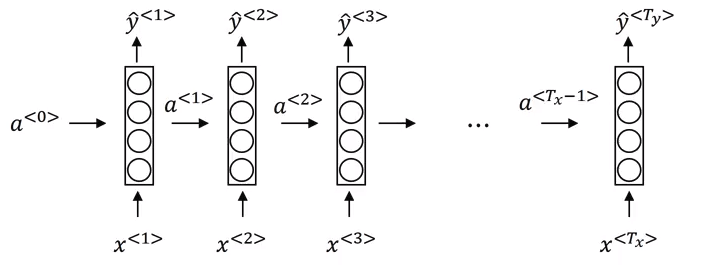

In [171]:
Image(filename='img/l7_17.png')